In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble, preprocessing

import pandas as pd, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


C:\Users\cheon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cheon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.00625

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = df.sample(n=1000000, random_state=1)
df_train = df.sample(n=10000, random_state=1)

In [5]:
print("Overall Dataset size:", len(df))
print("Test Dataset size:", len(df_test))
print("Train Dataset size:", len(df_train))


Overall Dataset size: 1600000
Test Dataset size: 1000000
Train Dataset size: 10000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Map target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
#df.target = df.target.apply(lambda x: decode_sentiment(x))
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 505 ms


Text(0.5,1,'Dataset labels distribuition')

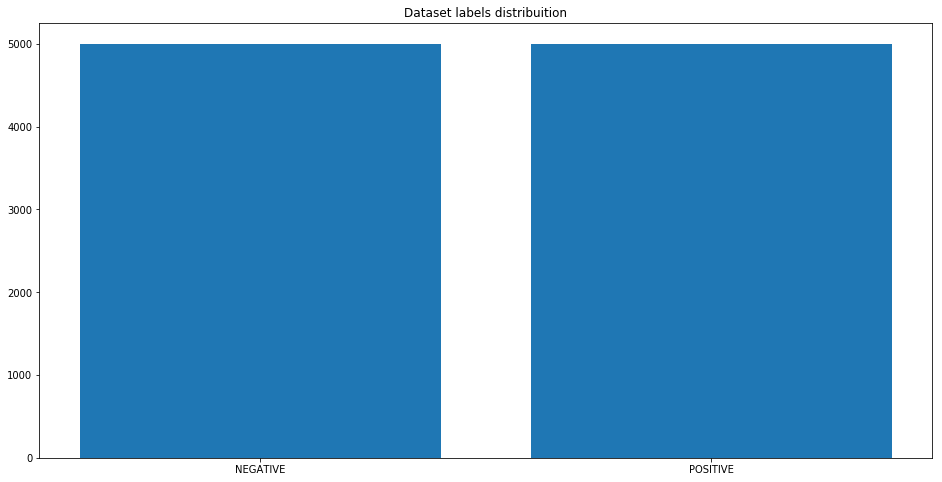

In [9]:
target_cnt = Counter(df_train.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Text(0.5,1,'Dataset labels distribuition')

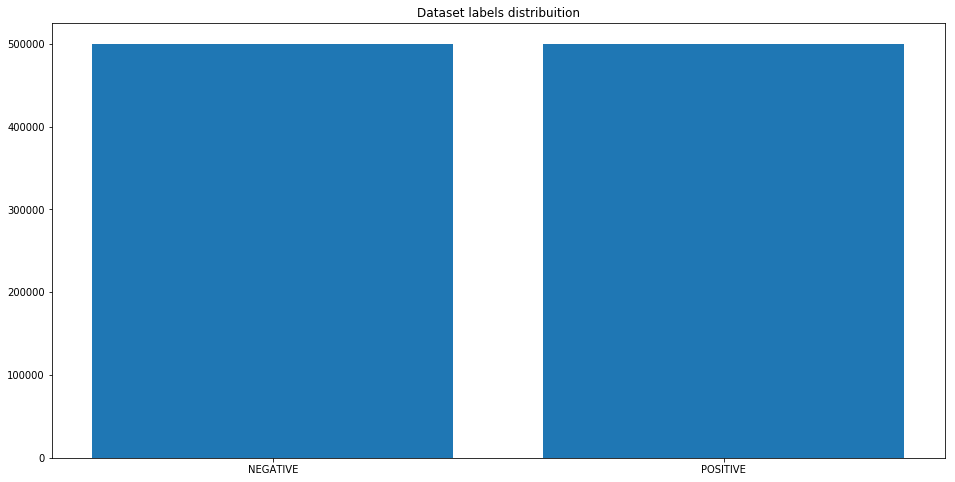

In [10]:
target_cnt = Counter(df_test.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Pre-process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

Tokenize text

In [13]:
%%time
max_features = 10000
tokenizer = Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 18953
Wall time: 272 ms


In [14]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 22.9 s


label encoders

In [15]:
labels_train = df_train.target.unique().tolist()
labels_train.append(NEUTRAL)
labels_train

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [16]:
labels_test = df_test.target.unique().tolist()
labels_test.append(NEUTRAL)
labels_test

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [17]:
#PLZ HELP CHECK WITH THE TOKENIZED PART
x_train = df_train['text']
y_train = df_train['target']
x_test = df_test['text']
y_test = df_test['target']

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (10000, 1)
y_test (1000000, 1)


In [18]:
df_train.head(5)

,target,ids,date,flag,user,text
514293,NEGATIVE,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...
142282,NEGATIVE,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,So I had a dream last night. I remember a sig...
403727,NEGATIVE,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,NEGATIVE,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again
610789,NEGATIVE,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,@MissKeriBaby wish I was in LA right now


In [19]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (10000,)
y_train (10000, 1)

x_test (1000000,)
y_test (1000000, 1)


2.1 Count Vectors as features

In [20]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_train['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train)

In [21]:
xtest_count = count_vect.transform(x_test)

In [22]:
xtest_count

<1000000x18607 sparse matrix of type '<class 'numpy.int64'>'
	with 11673377 stored elements in Compressed Sparse Row format>

In [23]:
len(df_test)

1000000

2.2 TF-IDF Vectors as features

a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

In [24]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=3500)
tfidf_vect.fit(df_train['text'])
xtrain_tfidf =  tfidf_vect.transform(x_train)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=3500)
tfidf_vect_ngram.fit(df_train['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df_train['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train) 

In [25]:
#FOR TESTING 
# word level tf-idf
#tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=3500)
#tfidf_vect.fit(df_test['text'])
xtest_tfidf =  tfidf_vect.transform(x_test)
#xtest_tfidf = xtest_tfidf.toarray()

# ngram level tf-idf 
#tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=3500)
#tfidf_vect_ngram.fit(df_test['text'])
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(x_test)

# characters level tf-idf
#tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
#tfidf_vect_ngram_chars.fit(df_test['text'])
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test) 

### word embeddings

In [0]:
#SEEMS LIKE REPETITION WITH THE TOKENIZE TEXT PART ABOVE
#FOR TRAINING
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec',encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df_train['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_train), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

FileNotFoundError: ignored

In [0]:
#SEEMS LIKE REPETITION WITH THE TOKENIZE TEXT PART ABOVE
#FOR TESTING
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec',encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
#token = text.Tokenizer()
#token.fit_on_texts(df_test['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

2.4 Text / NLP based features

A number of extra text based features can also be created which sometimes are helpful for improving text classification models. Some examples are:

Word Count of the documents – total number of words in the documents

Character Count of the documents – total number of characters in the documents

Average Word Density of the documents – average length of the words used in the documents

Puncutation Count in the Complete Essay – total number of punctuation marks in the documents

Upper Case Count in the Complete Essay – total number of upper count words in the documents

Title Word Count in the Complete Essay – total number of proper case (title) words in the documents

Frequency distribution of Part of Speech Tags:

Noun Count, Verb Count, Adjective Count, Adverb Count, Pronoun Count. These features are highly experimental ones and should be used according to the problem statement only.

In [0]:
df_train['char_count'] = df_train['text'].apply(len)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
df_train['word_density'] = df_train['char_count'] / (df_train['word_count']+1)
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df_train['title_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df_train['upper_case_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [0]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df_train['noun_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'noun'))
df_train['verb_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'verb'))
df_train['adj_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'adj'))
df_train['adv_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'adv'))
df_train['pron_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [0]:
#FOR TESTING
df_test['char_count'] = df_test['text'].apply(len)
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))
df_test['word_density'] = df_test['char_count'] / (df_test['word_count']+1)
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df_test['title_word_count'] = df_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df_test['upper_case_word_count'] = df_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [0]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df_test['noun_count'] = df_test['text'].apply(lambda x: check_pos_tag(x, 'noun'))
df_test['verb_count'] = df_test['text'].apply(lambda x: check_pos_tag(x, 'verb'))
df_test['adj_count'] = df_test['text'].apply(lambda x: check_pos_tag(x, 'adj'))
df_test['adv_count'] = df_test['text'].apply(lambda x: check_pos_tag(x, 'adv'))
df_test['pron_count'] = df_test['text'].apply(lambda x: check_pos_tag(x, 'pron'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

3.0 The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed

In [0]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

3.1 Logistic Regression

# Naive Bayes

3.2 Naive Bayes
Implementing a naive bayes model using sklearn implementation with different features

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature

In [0]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count)
print ("NB, Count Vectors: " + str(accuracy))

#Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print ("NB, WordLevel TF-IDF: " + str(accuracy))

# Naive Bayes on N-gram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print ("NB, ngramLevel Vectors: " + str(accuracy))

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: " + str(accuracy))


#Naive Bayes on word embeddings
accuracy = train_model(naive_bayes.MultinomialNB(), train_seq_x, y_train, test_seq_x )
print ("NB, Word Embeddings: " + str(accuracy))

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NB, Count Vectors: 0.732367
NB, WordLevel TF-IDF: 0.738448
NB, ngramLevel Vectors: 0.6651
NB, CharLevel Vectors: 0.710357
NB, Word Embeddings: 0.499328


In [0]:

### Naive Bayes Count Vectors 

NB, Count Vectors
F1 SCORE: 0.7067064544020937
Binary confusion matrix:
Predicted   False    True  __all__
Actual                            
False      409929   90323   500252
True       177310  322438   499748
__all__    587239  412761  1000000
             precision    recall  f1-score   support

          0       0.70      0.82      0.75    500252
          1       0.78      0.65      0.71    499748

avg / total       0.74      0.73      0.73   1000000

auc 0.8086617363550196


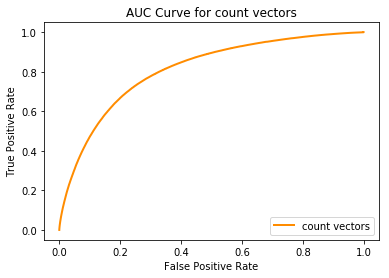

In [0]:
from matplotlib import pyplot as mp

print("NB, Count Vectors")
#y_train = y_train.ravel()
#y_test = y_test.ravel()
model = naive_bayes.MultinomialNB().fit(xtrain_count, y_train)
count_pred = model.predict(xtest_count)
print('F1 SCORE:', f1_score(count_pred, y_test))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, count_pred))
print(classification_report(y_test, count_pred))

count_pred = model.predict_proba(xtest_count)
count_pred = [i[0] for i in count_pred]

fpr,tpr,thresholds = metrics.roc_curve(y_test,count_pred, 0)
auc_count = metrics.auc(fpr,tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='count vectors' % auc_count)
auc = numpy.trapz(tpr,fpr)
print('auc',auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve for count vectors')
plt.legend(loc="lower right")
plt.savefig( "CountVectors.png")


NB, word level tfidf vectors
F1 SCORE: 0.729964566831581
Binary confusion matrix:
Predicted   False    True  __all__
Actual                            
False      384932  115320   500252
True       146232  353516   499748
__all__    531164  468836  1000000
             precision    recall  f1-score   support

          0       0.72      0.77      0.75    500252
          1       0.75      0.71      0.73    499748

avg / total       0.74      0.74      0.74   1000000

auc 0.8199859397695485


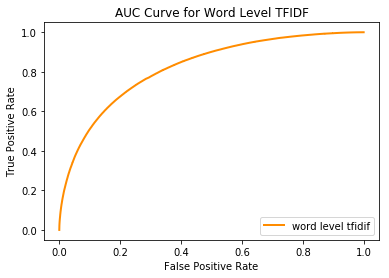

In [0]:
print("NB, word level tfidf vectors")
model = naive_bayes.MultinomialNB().fit(xtrain_tfidf, y_train)
tfidf_pred = model.predict(xtest_tfidf)
print('F1 SCORE:', f1_score(tfidf_pred, y_test))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, tfidf_pred))
print(classification_report(y_test, tfidf_pred))

tfidf_pred = model.predict_proba(xtest_tfidf)
tfidf_pred = [i[0] for i in tfidf_pred]

fpr,tpr,thresholds = metrics.roc_curve(y_test,tfidf_pred, 0)
auc_count = metrics.auc(fpr,tpr) 

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='word level tfidif' % auc_count)
auc = numpy.trapz(tpr,fpr)
print('auc',auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve for Word Level TFIDF')
plt.legend(loc="lower right")
plt.savefig( "wordleveltfidf.png")


NB, ngram level tfidf vectors
F1 SCORE: 0.6431897071577273
Binary confusion matrix:
Predicted   False    True  __all__
Actual                            
False      363253  136999   500252
True       197901  301847   499748
__all__    561154  438846  1000000
             precision    recall  f1-score   support

          0       0.65      0.73      0.68    500252
          1       0.69      0.60      0.64    499748

avg / total       0.67      0.67      0.66   1000000

auc 0.7499672566736827


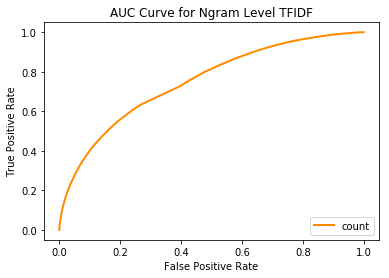

In [0]:
print("NB, ngram level tfidf vectors")
model = naive_bayes.MultinomialNB().fit(xtrain_tfidf_ngram, y_train)
tfidf_ngram_pred = model.predict(xtest_tfidf_ngram)
print('F1 SCORE:', f1_score(tfidf_ngram_pred, y_test))

print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, tfidf_ngram_pred))
print(classification_report(y_test, tfidf_ngram_pred))

tfidf_ngram_pred = model.predict_proba(xtest_tfidf_ngram)
tfidf_ngram_pred = [i[0] for i in tfidf_ngram_pred]

tpr,fpr,thresholds = metrics.roc_curve(y_test,tfidf_ngram_pred, 0)
auc_count = metrics.auc(fpr, tpr) 

plt.figure()
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(fpr,tpr)
print('auc',auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve for Ngram Level TFIDF')
plt.legend(loc="lower right")
plt.savefig( "ngramleveltfidf.png")


NB,character level tfidf vectors
F1 SCORE: 0.6908043976971763
Binary confusion matrix:
Predicted   False    True  __all__
Actual                            
False      386797  113455   500252
True       176188  323560   499748
__all__    562985  437015  1000000
             precision    recall  f1-score   support

          0       0.69      0.77      0.73    500252
          1       0.74      0.65      0.69    499748

avg / total       0.71      0.71      0.71   1000000

auc 0.7844969765067841


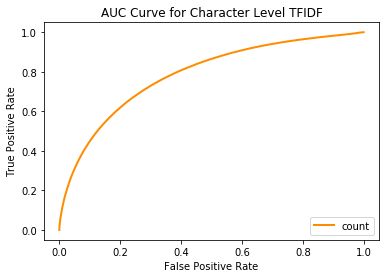

In [0]:
print("NB,character level tfidf vectors")
model = naive_bayes.MultinomialNB().fit(xtrain_tfidf_ngram_chars, y_train)
tfidf_ngram_chars_pred = model.predict(xtest_tfidf_ngram_chars)
print('F1 SCORE:', f1_score(tfidf_ngram_chars_pred, y_test))

print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, tfidf_ngram_chars_pred))
print(classification_report(y_test, tfidf_ngram_chars_pred))

tfidf_ngram_chars_pred = model.predict_proba(xtest_tfidf_ngram_chars)
tfidf_ngram_chars_pred = [i[0] for i in tfidf_ngram_chars_pred]

tpr,fpr,thresholds = metrics.roc_curve(y_test,tfidf_ngram_chars_pred, 0)
auc_count = metrics.auc(fpr, tpr) 

plt.figure()
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(fpr,tpr)
print('auc',auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve for Character Level TFIDF')
plt.legend(loc="lower right")
plt.savefig( "charleveltfidf.png")


NB,Word Embeddings
F1 SCORE: 0.550101720258506
Binary confusion matrix:
Predicted   False    True  __all__
Actual                            
False      193236  307016   500252
True       193656  306092   499748
__all__    386892  613108  1000000
             precision    recall  f1-score   support

          0       0.50      0.39      0.44    500252
          1       0.50      0.61      0.55    499748

avg / total       0.50      0.50      0.49   1000000

auc 0.5261207928590993


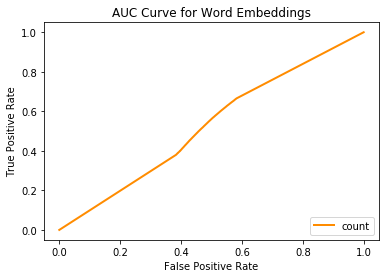

In [0]:
print("NB,Word Embeddings")
model = naive_bayes.MultinomialNB().fit(train_seq_x, y_train)
seq_pred = model.predict(test_seq_x)
print('F1 SCORE:', f1_score(seq_pred, y_test))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, seq_pred))
print(classification_report(y_test, seq_pred))

seq_pred = model.predict_proba((test_seq_x))
seq_pred = [i[0] for i in seq_pred]

tpr,fpr,thresholds = metrics.roc_curve(y_test,seq_pred , 0)
auc_count = metrics.auc(fpr, tpr) 

plt.figure()
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(fpr,tpr)
print('auc',auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve for Word Embeddings')
plt.legend(loc="lower right")
plt.savefig( "WordEmbeddings.png")



# SVM Model

3.3 Implementing a SVM Model
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes.

In [0]:
# SVM on Ngram Level TF IDF Vectors
#accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
#print ("SVM, N-Gram Vectors: "+str(accuracy))

In [0]:
from pandas_ml import ConfusionMatrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Count vectors

In [0]:
#xtrain_count, y_train, xtest_count

parameter_candidates = [
  {'C': [0.001, 0.0015, 0.002, 0.01], 
   'gamma': [0.1, 0.5, 1],
   'degree':[1, 2, 3],
   'kernel': ['poly', 'linear', 'rbf'], 
   'random_state':[0]}]
svm = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates)
svm.fit(xtrain_count, y_train)
print('score', svm.best_score_)
print('params',svm.best_params_)

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

score 0.699
params {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly', 'random_state': 0}


In [0]:
SVM = SVC(C=0.01, degree=2, gamma=1, kernel= 'poly', random_state=0,probability=True)
SVM.fit(xtrain_count, y_train,)
print('Accuracy_Score:', SVM.score(xtest_count, y_test))
SVM_pred = SVM.predict(xtest_count)
print('F1 SCORE:', f1_score(SVM_pred, y_test))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, SVM_pred))
print(classification_report(y_test, SVM_pred))

y_score = SVM.predict_proba(xtest_count)
y_score = [i[0] for i in y_score]

tpr,fpr,thresholds = metrics.roc_curve(y_test,y_score)
auc_count = metrics.auc(tpr,fpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(tpr,fpr)
print('auc',auc)


C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Word Level TF IDF Vectors

In [0]:
parameter_candidates = [
  {'C': [0.005, 0.01, 0.05, 0.07, 0.1], 
   'gamma': [0.007, 0.01, 0.05, 0.07, 0.1],
   'degree':[1, 2, 3],
   'kernel': ['poly'], 
   'random_state':[0]}]
svm = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates)
svm.fit(xtrain_tfidf, train_y)
print('score', svm.best_score_)
print('params',svm.best_params_)

In [0]:
SVM = SVC(C=0.01, degree=1, gamma=0.1, kernel= 'linear', random_state=0,probability=True)
SVM.fit(xtrain_tfidf, y_train)
print('Accuracy_Score:', SVM.score(xtest_tfidf, y_test))
SVM_pred = SVM.predict(xtest_tfidf)
print('F1 SCORE:', f1_score(SVM_pred, y_test))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(y_test, SVM_pred))
print(classification_report(y_test, SVM_pred))

y_score = SVM.predict_proba(xtest_tfidf)
y_score = [i[0] for i in y_score]

tpr,fpr,thresholds = metrics.roc_curve(y_test,y_score,0)
auc_count = metrics.auc(tpr,fpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(tpr,fpr)
print('auc',auc)

Accuracy_Score: 0.688683


### N-gram Level TF IDF Vectors

In [0]:
parameter_candidates = [
  {'C': [10, 100, 1000], 
   'gamma': [0.1, 0.001, 0.5, 1],
   'degree':[1, 2, 3],
   'kernel': ['poly', 'linear', 'rbf'], 
   'random_state':[0]}]
svm = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates)
svm.fit(xtrain_tfidf_ngram, train_y)
print('score', svm.best_score_)
print('params',svm.best_params_)

In [0]:
SVM = SVC(C=10, degree=1, gamma=0.1, kernel= 'linear', random_state=0, probability=True)
SVM.fit(xtrain_tfidf_ngram, train_y)
print('Accuracy_Score:', SVM.score(xtest_tfidf_ngram, test_y))
SVM_pred = SVM.predict(xtest_tfidf_ngram)
print('F1 SCORE:', f1_score(SVM_pred, test_y))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(test_y, SVM_pred))
print(classification_report(test_y, SVM_pred))

y_score = SVM.predict_proba(xtest_tfidf_ngram)
y_score = [i[0] for i in y_score]

tpr,fpr,thresholds = metrics.roc_curve(test_y,y_score,0)
auc_count = metrics.auc(tpr,fpr)

plt.figure()
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(fpr,tpr)
print('auc',auc)

### Character Level TF IDF Vectors

In [0]:
parameter_candidates = [
  {'C': [0.1, 1, 10], 
   'gamma': [0.1, 0.001, 0.5, 1],
   'degree':[1, 2, 3],
   'kernel': ['poly', 'linear', 'rbf'], 
   'random_state':[0]}]
svm = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates)
svm.fit(xtrain_tfidf_ngram_chars, train_y)
print('score', svm.best_score_)
print('params',svm.best_params_)

In [0]:
SVM = SVC(C=10, degree=1, gamma=0.1, kernel= 'linear', random_state=0, probability=True)
SVM.fit(xtrain_tfidf_ngram_chars, train_y)
print('Accuracy_Score:', SVM.score(xtest_tfidf_ngram_chars, test_y))
SVM_pred = SVM.predict(xtest_tfidf_ngram_chars)
print('F1 SCORE:', f1_score(SVM_pred, test_y))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(test_y, SVM_pred))
print(classification_report(test_y, SVM_pred))

y_score = SVM.predict_proba(xtest_tfidf_ngram_chars)
y_score = [i[0] for i in y_score]

tpr,fpr,thresholds = metrics.roc_curve(test_y,y_score,0)
auc_count = metrics.auc(tpr,fpr)

plt.figure()
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(fpr,tpr)
print('auc',auc)

### Word Embeddings

In [0]:
parameter_candidates = [
  {'C': [0.01, 0.1, 1, 10,100], 
   'gamma': [0.1, 0.01, 0.5, 1],
   'degree':[1, 2, 3],
   'kernel': ['poly', 'linear', 'rbf'], 
   'random_state':[0]}]
svm = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates)
svm.fit(train_seq_x, train_y)
print('score', svm.best_score_)
print('params',svm.best_params_)

In [0]:
SVM = SVC(C=0.01, degree=1, gamma=0.1, kernel= 'poly', random_state=0, probability=True)
SVM.fit(train_seq_x, train_y)
print('Accuracy_Score:', SVM.score(test_seq_x, test_y))
SVM_pred = SVM.predict(test_seq_x)
print('F1 SCORE:', f1_score(SVM_pred, test_y))
print("Binary confusion matrix:\n%s" % ConfusionMatrix(test_y, SVM_pred))
print(classification_report(test_y, SVM_pred))

y_score = SVM.predict_proba(test_seq_x)
y_score = [i[0] for i in y_score]

tpr,fpr,thresholds = metrics.roc_curve(test_y,y_score,0)
auc_count = metrics.auc(tpr,fpr)

plt.figure()
plt.plot(tpr, fpr, color='darkorange',
         lw=2, label='count' % auc_count)
auc = numpy.trapz(fpr,tpr)
print('auc',auc)

# CNN/RNN

3.4 Convolutional Neural Network (CNN)
In Convolutional neural networks, convolutions over the input layer are used to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters and combines their results.

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

model = Sequential()

# Embedding layer
model.add(
    Embedding(input_dim=max_features,
              input_length = xtrain_count.shape[1],
              output_dim=128))

# Recurrent layer
model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='sigmoid'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(100, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


labelencoder_y_1 = LabelEncoder()
y_train = labelencoder_y_1.fit_transform(y_train)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18607, 128)        1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
Total params: 1,340,068
Trainable params: 1,340,068
Non-trainable params: 0
_________________________________________________________________


C:\Users\cheon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# Load in embeddings
'''
glove_vectors = 'wiki-news-300d-1M.vec'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)

# Extract the vectors and words
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

# Create lookup of words to vectors
word_lookup = {word: vector for word, vector in zip(words, vectors)}

# New matrix to hold word embeddings
embedding_matrix = np.zeros((num_words, vectors.shape[1]))

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
        '''

NameError: name 'glove' is not defined

In [ ]:
print(xtrain_count.shape)
print(xtrain_count[0].shape)
print(xtrain_count[0:1].shape)
model.fit(xtrain_count, y_train,epochs=5,batch_size=32,verbose=2)

(10000, 18607)
(1, 18607)
(1, 18607)
Epoch 1/5


In [0]:
np.random.seed(1)
model_w2v_01 = Sequential()
model_w2v_01.add(Dense(256, activation='relu', input_dim=200))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(1, activation='sigmoid'))
model_w2v_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y_1 = LabelEncoder()
y_train = labelencoder_y_1.fit_transform(y_train)

model.fit(xtrain_count, y_train)

ValueError: ignored